In [1]:
import inspect
from time import time

import IPython.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import cache_sklearn_model
from prep_terrain_data import makeTerrainData

np.random.seed(31415)

# Lesson 5: Choose Your Own Algorithm

Algorithms to choose from:
- Naive Bayes
- SVM
- Decision Tree
- AdaBoost
- Random Forest
- KNN

Data set to evaluate: `makeTerrainData` from `prep_terrain_data`

This is a generated dataset of fake terrain conditions.

**Goal**: Can You Beat Our High Score? 93.6%

## Graph the data

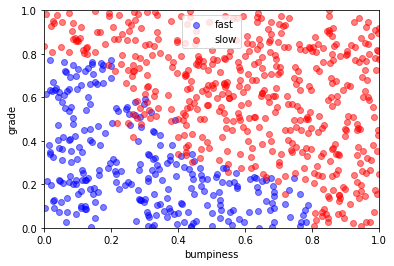

In [25]:
def graph_grade_vs_speed(points = 1000):
    """
    the training data (features_train, labels_train) have both "fast" and "slow"
    points mixed together--separate them so we can give them different colors
    in the scatter plot and identify them visually
    """
    features_train, labels_train, features_test, labels_test = makeTerrainData(points)
    grade_fast = [features_train[ii][0] for ii in range(0, len(features_train)) if labels_train[ii] == 0]
    bumpy_fast = [features_train[ii][1] for ii in range(0, len(features_train)) if labels_train[ii] == 0]
    grade_slow = [features_train[ii][0] for ii in range(0, len(features_train)) if labels_train[ii] == 1]
    bumpy_slow = [features_train[ii][1] for ii in range(0, len(features_train)) if labels_train[ii] == 1]

    # initial visualization
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.scatter(bumpy_fast, grade_fast, color=(0.0, 0.0, 1.0, 0.5), label="fast")
    plt.scatter(grade_slow, bumpy_slow, color=(1.0, 0.0, 0.0, 0.5) , label="slow")
    plt.legend()
    plt.xlabel("bumpiness")
    plt.ylabel("grade")
    plt.show()


graph_grade_vs_speed()

## How to Measure success

- what defines a model? model name, params, data_desc
- where can we store meta data on scores against test_data
- save scores to dict so we can see a running tally of the top performing models at any point

In [3]:
classifier_performance_store = {}

In [4]:
def measure_effectiveness_of_classifier(classifier, data_description, features_test, labels_test):
    # identify using: classifier name, classifier params, data desc
    classifier_key = cache_sklearn_model.get_hash_of_model_and_data(classifier, data_description)

    # measure:
    # - inference speed
    t = time()
    labels_pred = classifier.predict(features_test)
    inference_speed = time() - t

    # - accuracy score
    # - recall
    # - precision
    report = classification_report(labels_test, labels_pred, output_dict=True)
    classifier_performance = {
        "key": classifier_key,
        "classifier": type(classifier).__name__,
        "data_description": data_description,
        "params": classifier.get_params(),
        "accuracy": report['accuracy'],
        "recall": report['1.0']['recall'],
        "precision": report['1.0']['precision'],
        "f1_score": report['1.0']['f1-score'],
        "inference_speed": inference_speed,
    }

    if classifier_key in classifier_performance_store:
        print('measurement has already been taken on this model in this configuration')
        print(classifier_performance_store[classifier_key])
        print(classifier_performance)
    else:
        classifier_performance_store[classifier_key] = classifier_performance

    return classifier_key

In [5]:
def display_classifier_table(classifier_key=None):
    classifiers_to_display = []
    # requested classifier
    if classifier_key is not None:
        classifiers_to_display.append(classifier_performance_store[classifier_key])
    # top classifiers
    classifiers_to_display.extend(sorted(
        classifier_performance_store.values(),
        key=lambda metric: metric["accuracy"],
        reverse=True
    )[0:5])

    table_header = """
| Accuracy | dataset | classifier | params |
| - | - | - | - |
"""
    table_row_template = "| {accuracy:.3f} | {data_description} | {classifier} | {params} |"
    table_rows = [table_row_template.format(**metric) for metric in classifiers_to_display]

    # noinspection PyTypeChecker
    return IPython.display.display(IPython.display.Markdown(table_header + '\n'.join(table_rows)))

In [6]:
def optimize_model(gen_data, classifier_class, add_random_state=True, **kwargs):
    data_desc, features_train, labels_train, features_test, labels_test = gen_data()

    clf = classifier_class(random_state=27, **kwargs) if add_random_state else classifier_class(**kwargs)
    clf, fit_delta = cache_sklearn_model.train_model_cached(data_desc, clf, features_train, labels_train)

    # measure and display effectiveness
    return measure_effectiveness_of_classifier(clf, data_desc, features_test, labels_test)

## An Approach to Classification

constraints:
- not allowed to increase or decrease the amount of data used

#### Feature analysis:

- two features
    - grade: slope of the terrain
    - bumpy: roughness of the terrain
- Ways to combine:
    - cross product (grade * bumpy)

#### Take an initial pass using each of the following classifier:

- Naive Bayes
    - sklearn.naive_bayes.GaussianNB
- sklearn.svm.SVC
    - kernel: ‘rbf’, ‘linear’, ‘poly’, ‘sigmoid’
- sklearn.tree.DecisionTreeClassifier
    - min_sample_split: 2, 3, 4
    - criterion: entropy, gini
- sklearn.ensemble.AdaBoostClassifier
    - base_estimator: ?
    - algorithm: ?
    - learning_rate vs n_estimators
- sklearn.ensemble.RandomForestClassifier
    - depends on DecisionTreeClassifier
- sklearn.neighbors.KNeighborsClassifier
    - n_neighbors
    - weights
    - n_jobs: -1 (use all processors)

#### Look deeper into 2-3 classifiers that perform well

Fine tune the parameters of the classifiers that did the best in the first round.

In [7]:
def terrain_data_with_feature_cross_n_points_1000():
    def transform_features(features):
        return [[x, y, x * y] for x, y in features]

    features_train, labels_train, features_test, labels_test = makeTerrainData()

    features_train = transform_features(features_train)
    features_test = transform_features(features_test)

    data_desc = inspect.stack()[0][3]

    return data_desc, features_train, labels_train, features_test, labels_test


def terrain_data_1000_points():
    features_train, labels_train, features_test, labels_test = makeTerrainData()
    data_desc = inspect.stack()[0][3]
    return data_desc, features_train, labels_train, features_test, labels_test


data_to_try = [terrain_data_1000_points, terrain_data_with_feature_cross_n_points_1000]

## Naive Bayes using sklearn.naive_bayes.GaussianNB

In [8]:
for data_gen in data_to_try:
    optimize_model(data_gen, GaussianNB, add_random_state=False)

## SVM
- sklearn.svm.SVC
    - kernel: ‘rbf’, ‘linear’, ‘poly’, ‘sigmoid’

In [9]:
for data_gen in data_to_try:
    for kernel in ['rbf', 'linear', 'poly', 'sigmoid']:
        optimize_model(data_gen, svm.SVC, kernel=kernel)

## Decision Tree
- sklearn.tree.DecisionTreeClassifier
    - min_sample_split: 2, 3, 4
    - criterion: entropy, gini

In [10]:
for data_gen in data_to_try:
    for criterion in ['entropy', 'gini']:
        for min_samples_split in range(2, 5):
            optimize_model(
                data_gen,
                DecisionTreeClassifier,
                criterion=criterion,
                min_samples_split=min_samples_split,
            )

## Ada Boost
- sklearn.ensemble.AdaBoostClassifier
    - base_estimator: ?
    - algorithm: ?
    - learning_rate vs n_estimators

In [11]:
for data_gen in data_to_try:
    optimize_model(
        data_gen,
        AdaBoostClassifier,
    )

## Random Forest
- sklearn.ensemble.RandomForestClassifier
    - depends on DecisionTreeClassifier

In [12]:
for data_gen in data_to_try:
    optimize_model(
        data_gen,
        RandomForestClassifier,
    )

## K-Nearest Neighbors
- sklearn.neighbors.KNeighborsClassifier
    - n_neighbors
    - weights
    - n_jobs: -1 (use all processors)

In [13]:
for data_gen in data_to_try:
    optimize_model(
        data_gen,
        KNeighborsClassifier,
        add_random_state=False
    )

In [14]:
display_classifier_table()


| Accuracy | dataset | classifier | params |
| - | - | - | - |
| 0.928 | terrain_data_1000_points | SVC | {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 27, 'shrinking': True, 'tol': 0.001, 'verbose': False} |
| 0.928 | terrain_data_with_feature_cross_n_points_1000 | RandomForestClassifier | {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 27, 'verbose': 0, 'warm_start': False} |
| 0.928 | terrain_data_with_feature_cross_n_points_1000 | KNeighborsClassifier | {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'} |
| 0.924 | terrain_data_with_feature_cross_n_points_1000 | SVC | {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 27, 'shrinking': True, 'tol': 0.001, 'verbose': False} |
| 0.924 | terrain_data_with_feature_cross_n_points_1000 | DecisionTreeClassifier | {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 27, 'splitter': 'best'} |

#### Look deeper into 2-3 classifiers that perform well

##### Acc 0.928
classifier: RandomForestClassifier
data: terrain_data_with_feature_cross_n_points_1000

classifier: SVC
data: terrain_data_1000_points
kernel: rbf

classifier: KNeighborsClassifier
data: terrain_data_with_feature_cross_n_points_1000

The next steps would be to double down on these three classifiers and figure find out the best parameters for this data.

# Conclusion

I'm happy with the accuracy that was achieved during this lesson. There is definitely more room to improve.

I'm surprised that AdaBoost didn't do well on this dataset.
Based on my reading I expected the boosting algorithm to outperform the random tree.
This is an area I would dig further.

The approach of trying each classifier at a cursory level has pros and cons.
A benefit is that a decently accurate solution was found rather quickly.
However, the downside is that models requiring fine grained tuning will underperform.

### Try with more data

In [15]:
def terrain_data_points(points=1000):
    data_desc = inspect.stack()[0][3] + f'_{points}'

    def terrain_data_points_generator():
        features_train, labels_train, features_test, labels_test = makeTerrainData(points)
        return data_desc, features_train, labels_train, features_test, labels_test

    return terrain_data_points_generator


def terrain_data_with_feature_cross_points(points=1000):
    def transform_features(features):
        return [[x, y, x * y] for x, y in features]

    def terrain_data_with_feature_cross_points_generator():
        features_train, labels_train, features_test, labels_test = makeTerrainData(points)

        features_train = transform_features(features_train)
        features_test = transform_features(features_test)

        data_desc = inspect.stack()[0][3] + f'_{points}'

        return data_desc, features_train, labels_train, features_test, labels_test

    return terrain_data_with_feature_cross_points_generator



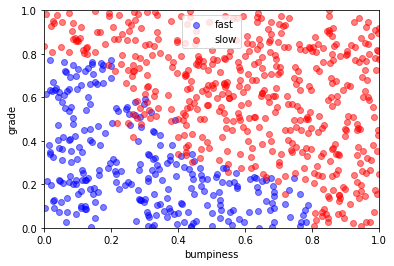

In [26]:
graph_grade_vs_speed(1000)

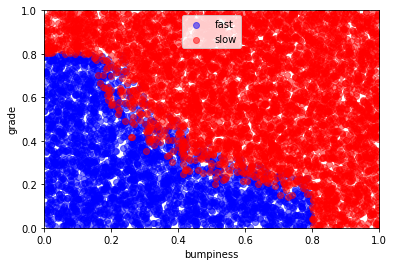

In [27]:
graph_grade_vs_speed(10000)

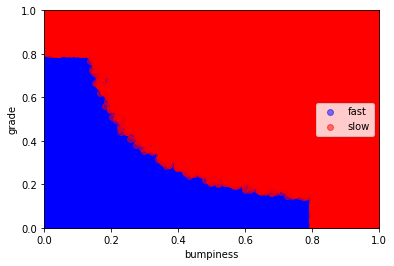

In [28]:
graph_grade_vs_speed(100000)

In [16]:
for points in [1000, 10000, 100000]:
    optimize_model(terrain_data_points(points), svm.SVC, kernel='rbf')
    optimize_model(terrain_data_with_feature_cross_points(points), RandomForestClassifier)
    optimize_model(terrain_data_with_feature_cross_points(points), KNeighborsClassifier, add_random_state=False)

display_classifier_table()


| Accuracy | dataset | classifier | params |
| - | - | - | - |
| 0.961 | terrain_data_with_feature_cross_points_generator_10000 | KNeighborsClassifier | {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'} |
| 0.959 | terrain_data_points_100000 | SVC | {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 27, 'shrinking': True, 'tol': 0.001, 'verbose': False} |
| 0.959 | terrain_data_points_10000 | SVC | {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 27, 'shrinking': True, 'tol': 0.001, 'verbose': False} |
| 0.959 | terrain_data_with_feature_cross_points_generator_100000 | RandomForestClassifier | {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 27, 'verbose': 0, 'warm_start': False} |
| 0.958 | terrain_data_with_feature_cross_points_generator_10000 | RandomForestClassifier | {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 27, 'verbose': 0, 'warm_start': False} |

More data did help get a higher accuracy